In [1]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import copy
import pylab
sns.set()

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [38]:
#####################################

def load_yelp():
    # Load a csv of floats:
    X = np.genfromtxt("upvote_data.csv", delimiter=",")
    # Load a text file of integers:
    y = np.loadtxt("upvote_labels.txt", dtype=np.int)
    # Load a text file of strings:
    featureNames = open("upvote_features.txt").read().splitlines()
    
    # demean!
    X = pylab.demean(X,axis=0)
    return X,y,featureNames

def split(data,labels):
    n_train = 4000
    n_valid = 1000
    n_test = 1000
    
    train_d = data[0:n_train,:]
    train_l = labels[0:n_train]
    
    valid_d = data[n_train:n_train+n_valid,:]
    valid_l = labels[n_train:n_train+n_valid]
    
    test_d = data[n_valid::,:]
    test_l = labels[n_valid::]
    
    return train_d,valid_d,test_d,train_l,valid_l,test_l

### lasso!

def lambda_max_func(x,y):
    k = np.shape(x)[1]
    n = np.shape(x)[0]
    lambda_vec = []
    sum_y = (1/n)*np.sum(y[:])
    k_range = np.arange(k)
    lambda_max = np.max([2*np.abs(np.dot(x[:,k_ind].T,(y-sum_y))) for k_ind in k_range])
    return lambda_max

def lasso_CD(x,y,lambda_val,w_init):
    ### initialize conditions 
    delta = 1e-3
    n = np.shape(x)[0]
    d = np.shape(x)[1]

    stop_cond = 100
    w = w_init
    a = np.zeros((d,))
    c = np.zeros((d,))
    stop_cond_vec = []
    w_old = np.zeros((d,))

    while(stop_cond>delta):
        diff_y_x = y - np.dot(x,w)
        w_0 = (1/n)*np.sum(diff_y_x)

        for k in np.arange(d):
            a[k] = 2*np.dot(x[:,k].T,x[:,k])

            # subtract version
            
            diff_y_x_w0 = y - w_0 - np.dot(x,w) + np.dot(x[:,k],w[k])
            
            # bool version
#             mask = np.ones(d,dtype=bool)
#             mask[k] = 0
#             x_temp = x[:,mask]
#             w_temp = w[mask]

#             diff_y_x_w0 = y - w_0 - np.dot(x_temp,w_temp)
            
            c[k] = 2*np.dot(x[:,k].T,diff_y_x_w0)

            if c[k] < - lambda_val:
                w[k] = ((c[k]+lambda_val))/a[k]
            elif (-lambda_val < c[k] < lambda_val):
                w[k] = 0
            elif c[k] > lambda_val:
                w[k] = ((c[k]-lambda_val))/a[k]

        weight_diff = w - w_old
        w_old = np.array(w)
        
        # use maximum of weight difference 
        #stop_cond = np.max(weight_diff)
        
        # use mean weight difference 
        
        stop_cond = np.abs(np.mean(weight_diff))
        print('value of lasso run {}'.format(stop_cond))
        #stop_cond_vec.append(stop_cond)
    
    return w

def lasso_loop(x_t,y_t,x_v,y_v):
    w_vec = []
    num_non_zero_vec = []
    lambda_val = lambda_max_func(x_t,y_t)
    lambda_vec = []
    valid_error_vec=[]
    train_error_vec = []
    valid_error_diff = 100
    valid_error_old = 100
    valid_error_delta = 1e-2
    lambda_ratio = 3/5

    w_init = np.random.random(np.shape(x_t)[1])
    
    while (valid_error_diff>valid_error_delta):
        print('the value of lambda is {}'.format(lambda_val))
        w = lasso_CD(x_t,y_t,lambda_val,w_init)
        
        # total non zero 
        num_non_zero = sum((np.abs(x)>0 for x in w))
        
        w_vec.append(w)

        w_init = np.array(w)
        
        train_error = error_calc(x_t,y_t,w)
        valid_error = error_calc(x_v,y_v,w)
        
        num_non_zero_vec.append(num_non_zero)
        lambda_vec.append(lambda_val)
        lambda_val = lambda_val*lambda_ratio

        train_error_vec.append(train_error)
        valid_error_vec.append(valid_error)
        valid_error_diff = np.abs(valid_error - valid_error_old)
        valid_error_old = copy.copy(valid_error)

        print('The validation error was {}'.format(valid_error))
        print('The validation error difference was {}'.format(valid_error_diff))
    
    return w_vec,num_non_zero_vec,lambda_vec,valid_error_vec,train_error_vec

def error_calc(x,y,w):
    n = np.shape(y)[0]
    error = (1/n)*np.sum((y-np.dot(x,w))**2)
    return error

def plot_valid_train(train_error_vec,valid_error_vec,num_non_zero_vec,lambda_vec):
   
    ax1= plt.figure(figsize=(4, 4), dpi=600)
    plt.plot(lambda_vec,train_error_vec,label='training error')
    plt.plot(lambda_vec,valid_error_vec,label='validation error')
    plt.xlabel(r'$ \lambda $')
    plt.title('Training and Validation error for' +'\n' +'various values of Lambda ')
    plt.ylabel('error')
    plt.legend()
    plt.savefig('hw2_valid_train_error_kaggle.png')

    ax2 = plt.figure(figsize=(4, 4), dpi=600)
    plt.plot(lambda_vec,num_non_zero_vec)
    plt.xlabel(r'$ \lambda $')
    plt.ylabel('Number of non zero entries')
    plt.title('Number of non zero entries for ' + '\n' + 'various values of lambda')
    plt.savefig('hw2_nonzero_kaggle.png')
    
def plot_lasso(w,stop_cond_vec,w_star):
    ax1 = sns.distplot(w, rug=True,hist=True,bins=100, kde=False, rug_kws={"color": "g"},hist_kws={"histtype": "step", "linewidth": 3, "alpha": 1, "color": "g"})

    plt.figure()
    ax3 = plt.bar(np.arange(len(w_star)),w_star,label='w*')
    ax2 = plt.bar(np.arange(len(w)),1.1*w,label='computed weight matrix')
    plt.legend()
    plt.ylim([-10,10])

    plt.figure()
    ax3 = plt.plot(np.arange(len(stop_cond_vec)),stop_cond_vec)
    plt.ylim([0,0.05])

### part a

In [3]:
# load data
X,y,featureNames = load_yelp()

# split data
train_d,valid_d,test_d,train_l,valid_l,test_l = split(X,y)


In [32]:
w_vec,num_non_zero_vec,lambda_vec,valid_error_vec,train_error_vec = lasso_loop(train_d,train_l,valid_d,valid_l)



the value of lambda is 145.92594572640883
value of lasso run 0.11292484038172095
value of lasso run 0.11220942120112352
value of lasso run 0.0007155250865177923
The validation error was 7.259994738137149
The validation error difference was 92.74000526186285
the value of lambda is 87.55556743584529
value of lasso run 0.04969398638785739
value of lasso run 0.0032599263901792615
value of lasso run 0.0020406124092950608
value of lasso run 1.30674854463253e-05
The validation error was 5.554684176037527
The validation error difference was 1.7053105620996218
the value of lambda is 52.53334046150717
value of lasso run 0.07465386087773213
value of lasso run 0.0016319972494742954
value of lasso run 0.00106258019824363
value of lasso run 0.0005207778627551462
The validation error was 4.918925142142227
The validation error difference was 0.6357590338953001
the value of lambda is 31.520004276904302
value of lasso run 0.09388550908478696
value of lasso run 0.0013292932150859435
value of lasso run 0.

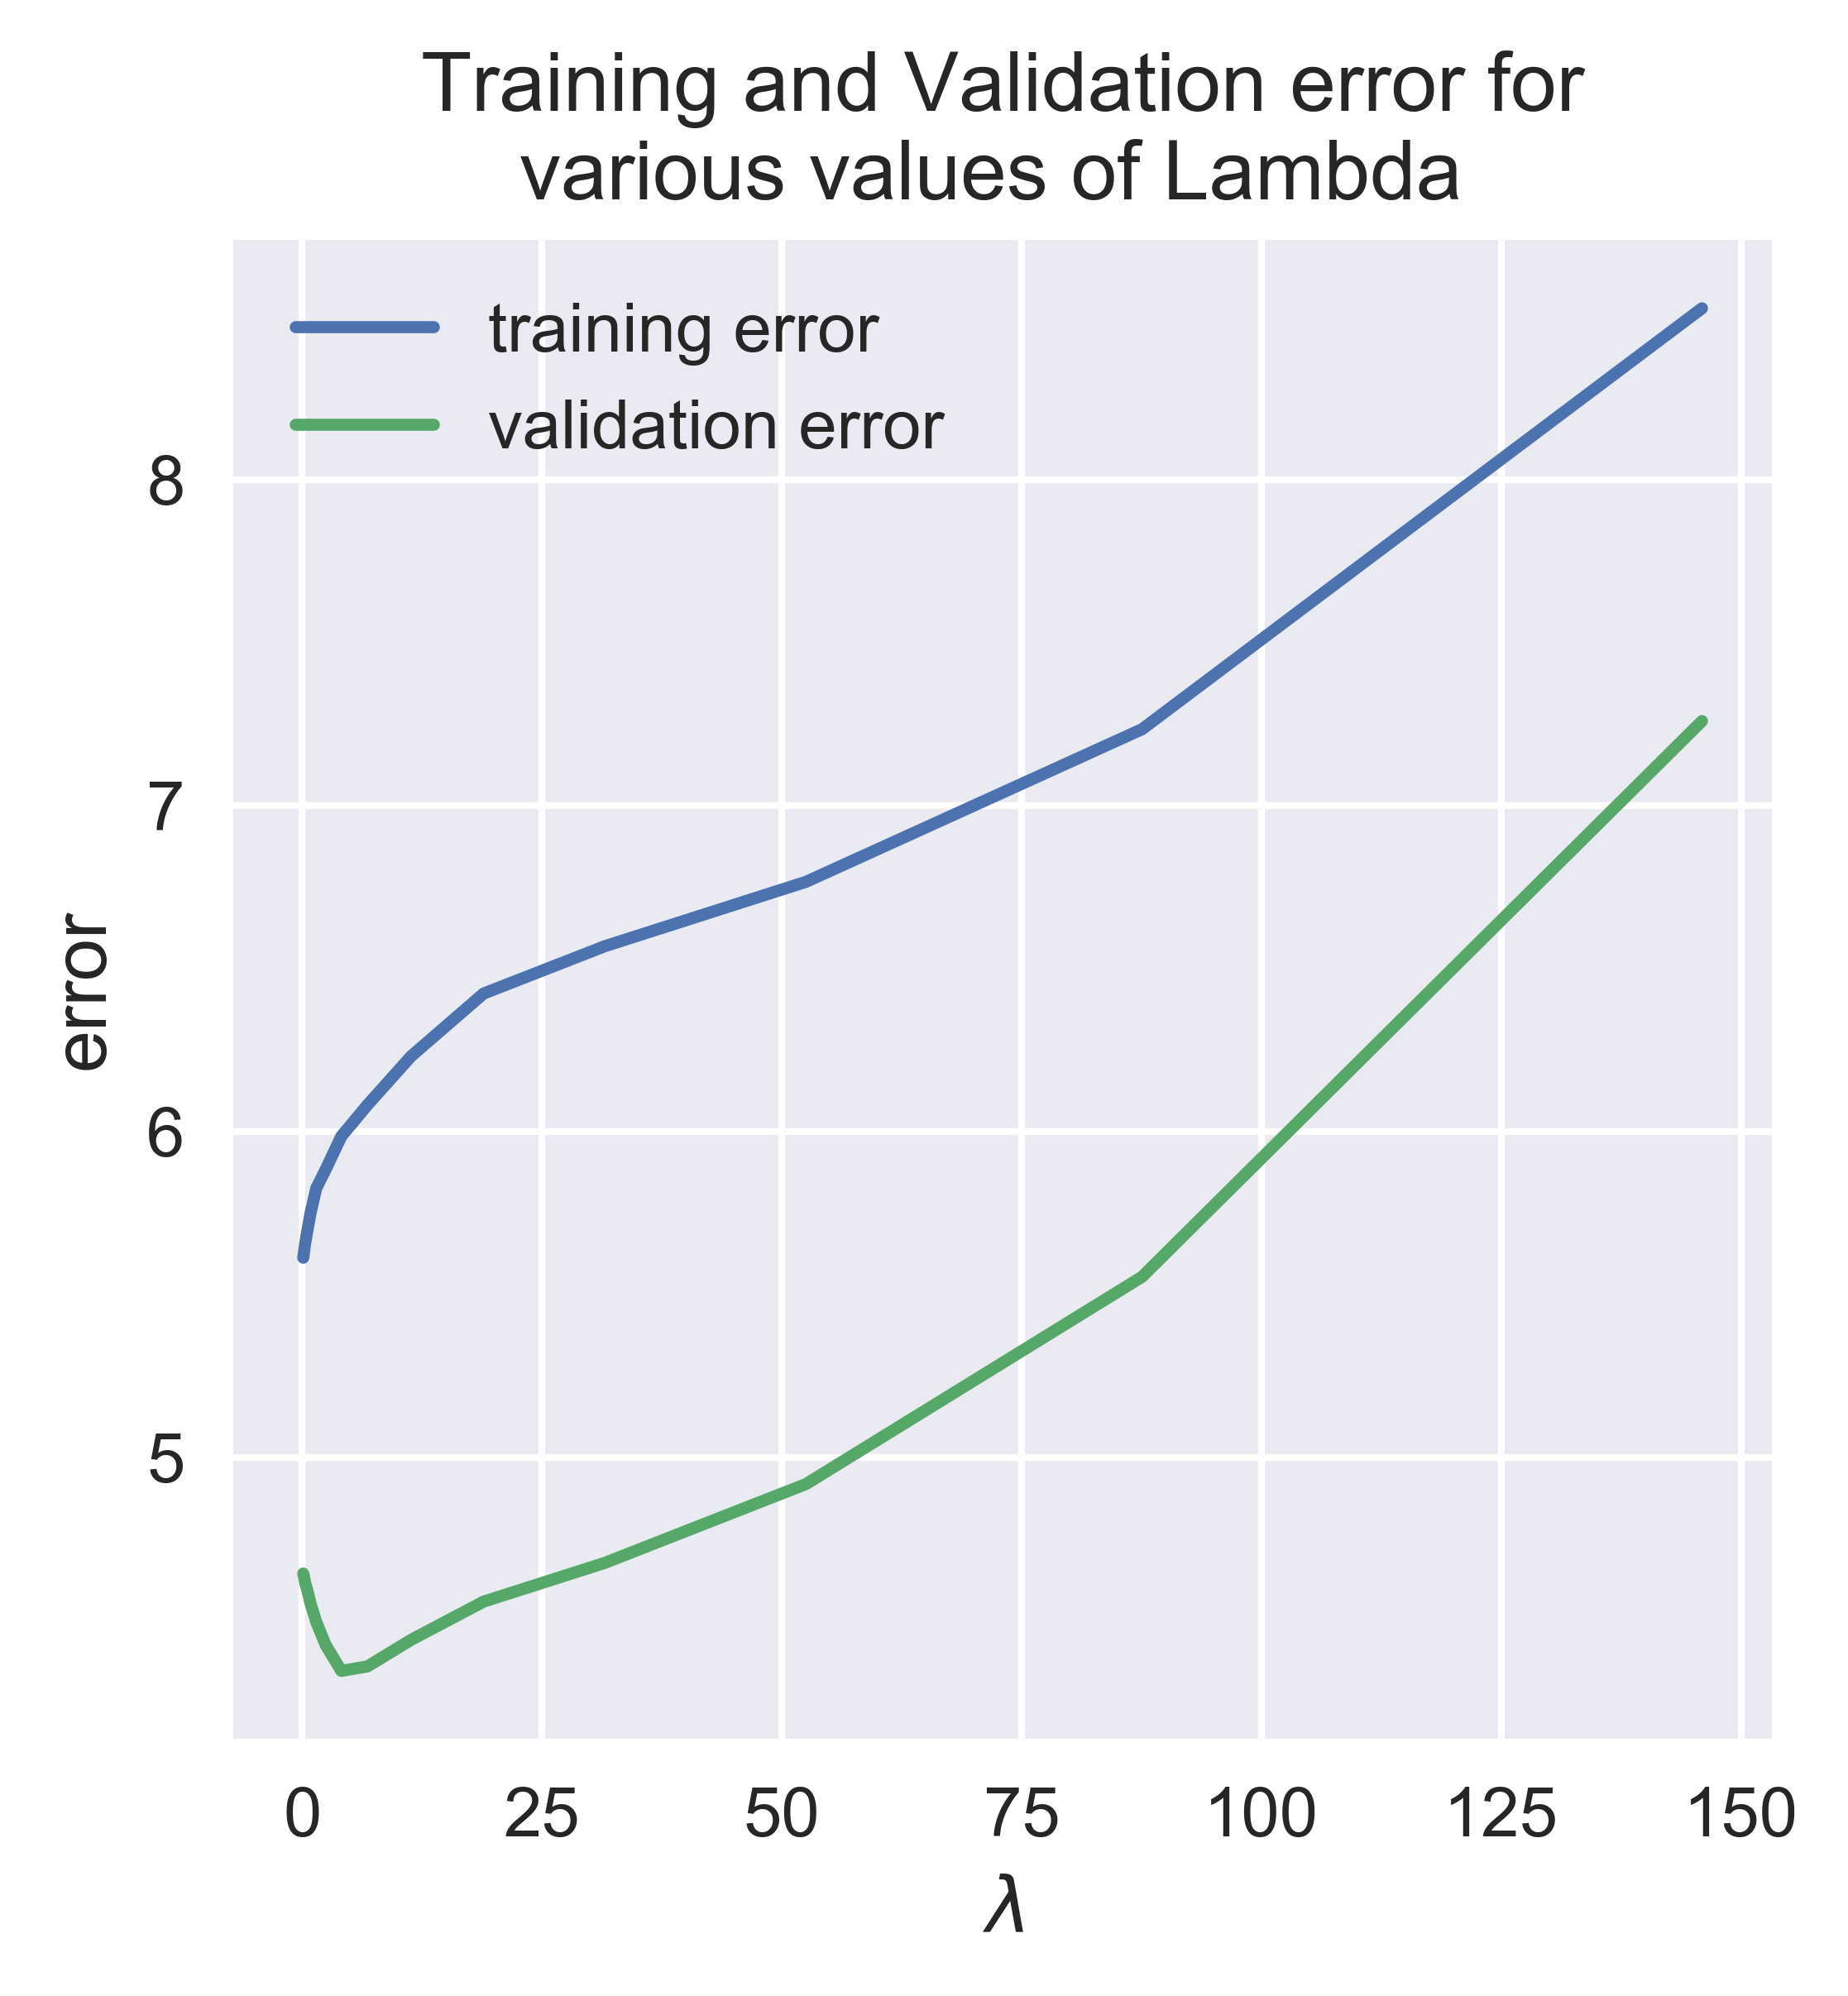

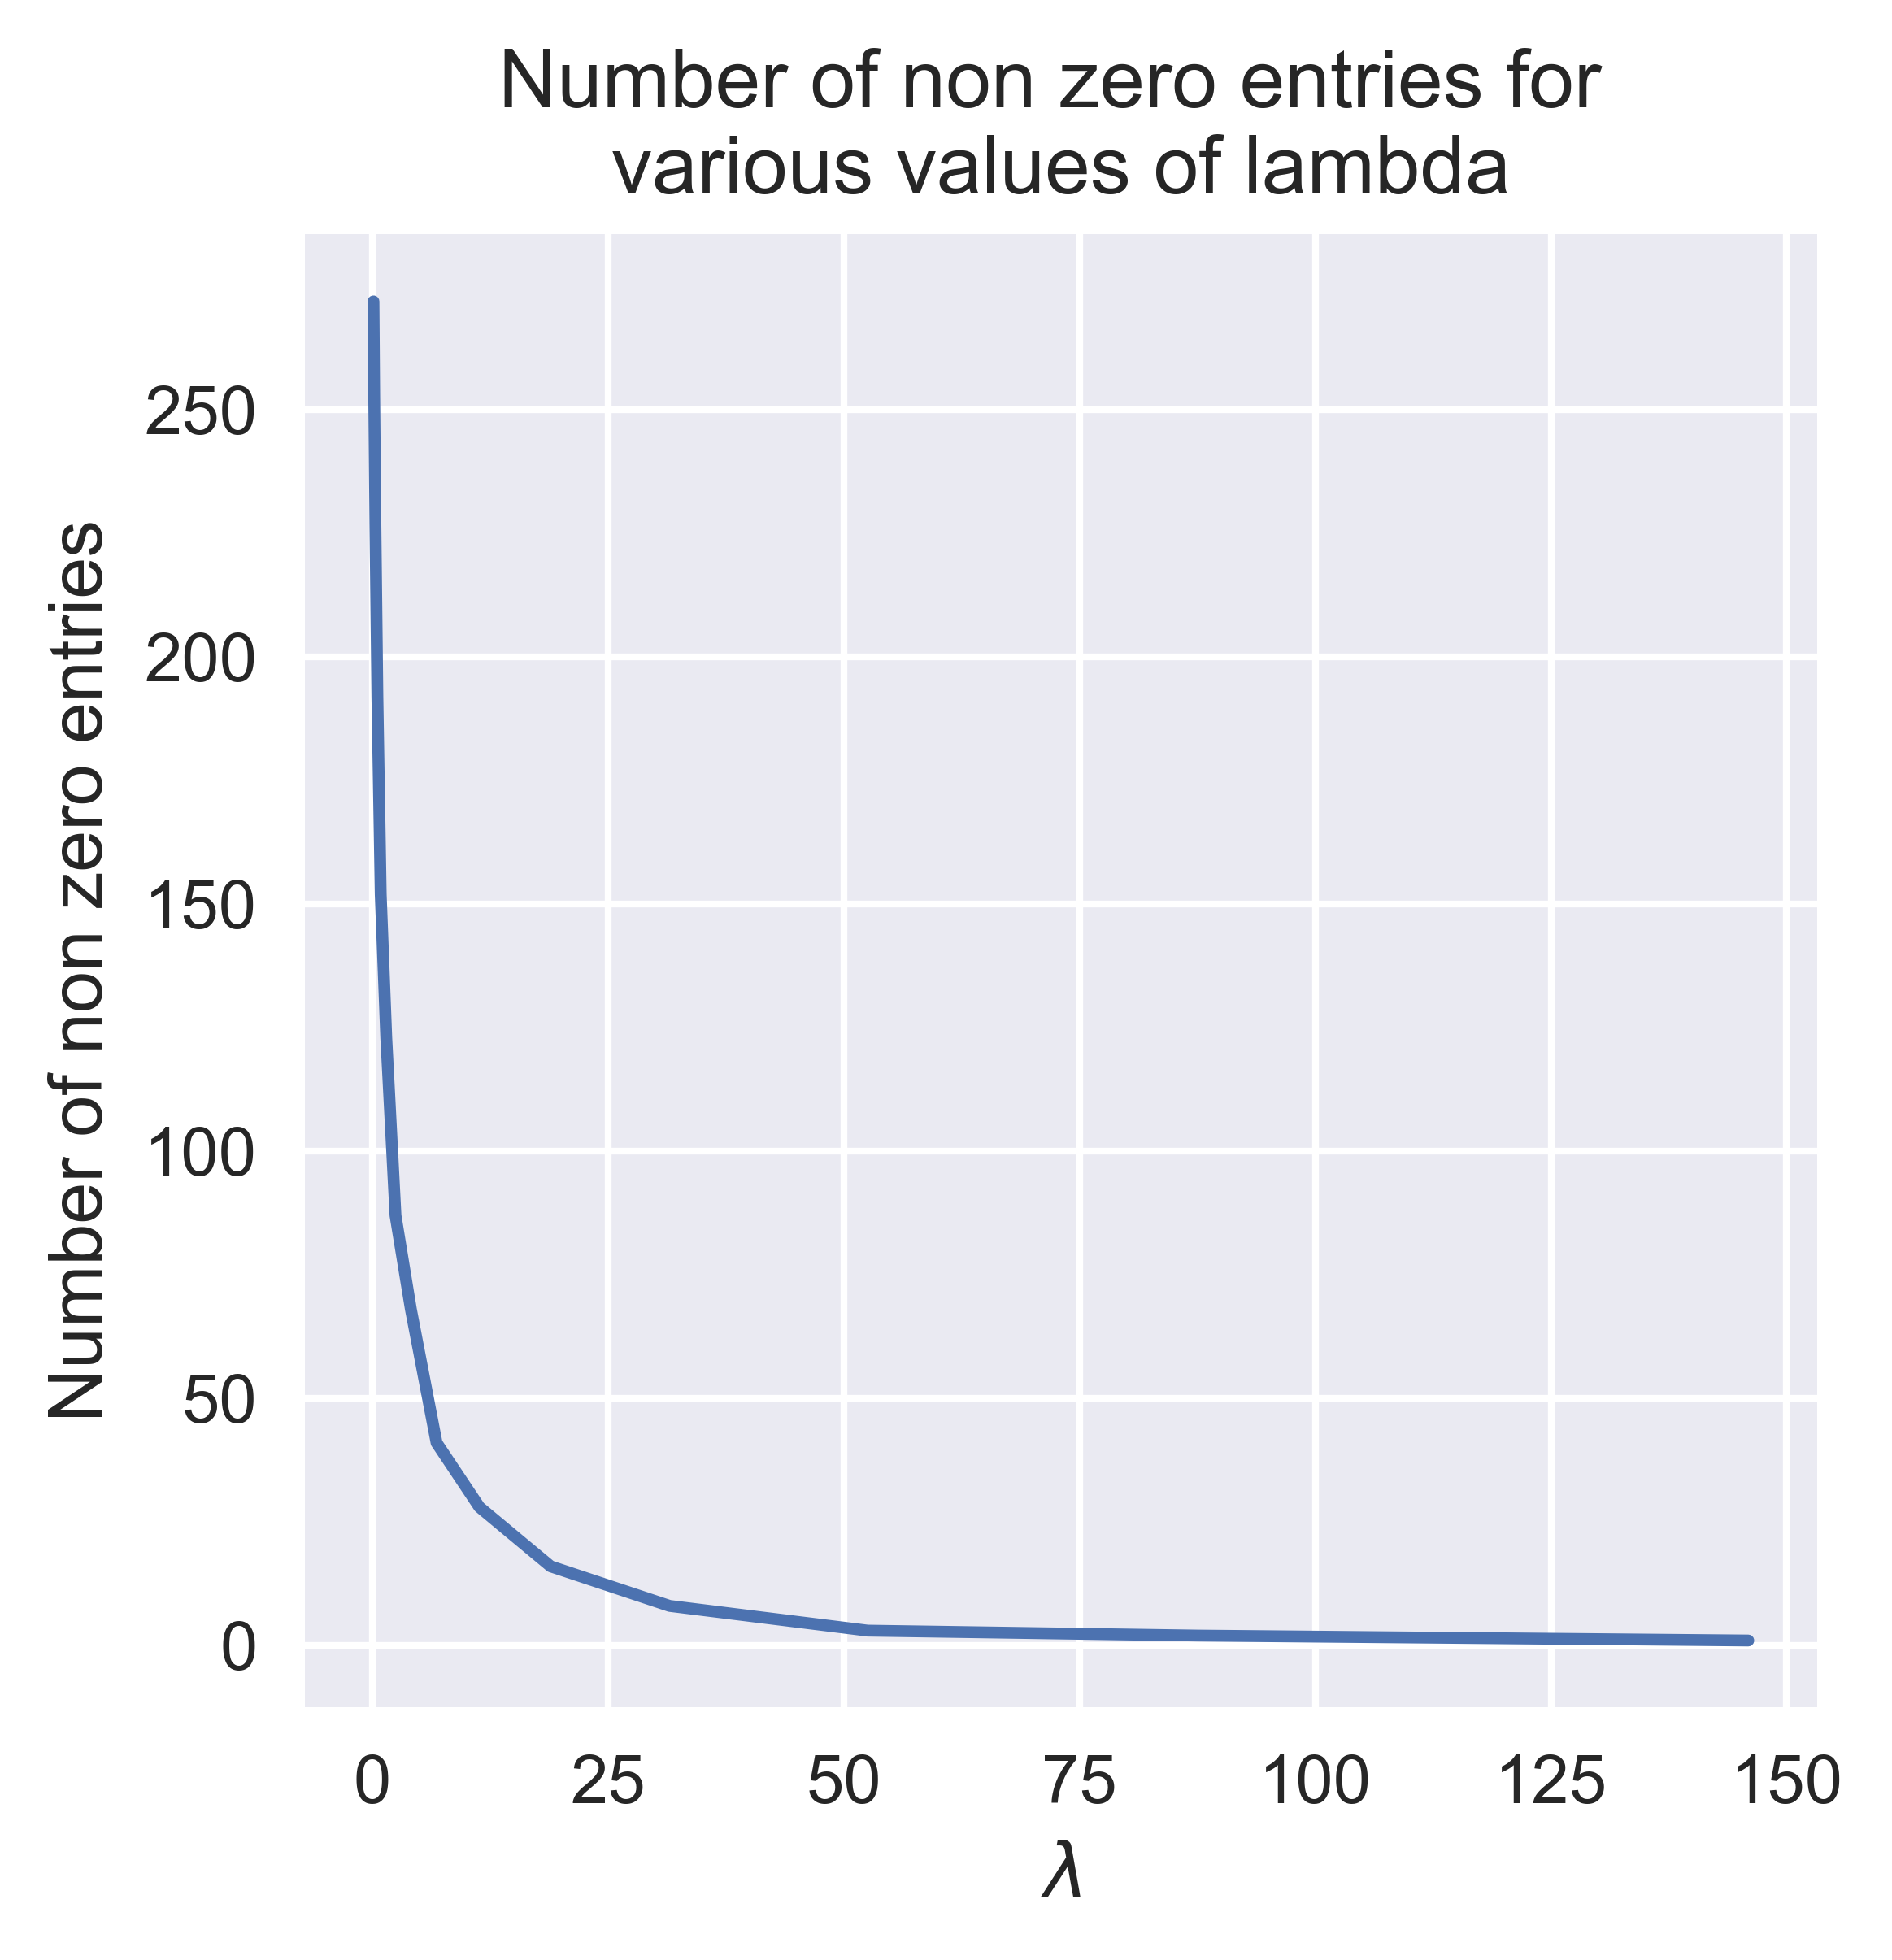

In [40]:
plot_valid_train(train_error_vec,valid_error_vec,num_non_zero_vec,lambda_vec)

### part b

In [54]:
ind_valid_min
np.shape(ind_valid_min)
np.shape(w_vec)
type(ind_valid_min)
type(w_vec)

array(7, dtype=int64)

()

(15, 1000)

numpy.ndarray

list

In [76]:
# lambda optimal
ind_valid_min = np.array(np.argmin(valid_error_vec))
lambda_opt = lambda_vec[ind_valid_min]
w_vec_array = np.array(w_vec)
w_best = w_vec_array[ind_valid_min,:]

test_error = error_calc(test_d,test_l,w_best)
print('The test error is {}'.format(test_error))


The test error is 6.239866784991444


### part c

In [64]:
featureNamesArray = np.array(featureNames)

In [78]:
inds_top10 = np.argpartition(w_best, -10)[-10:]

top10_weight = w_best[inds_top10]
top10_feat = featureNamesArray[inds_top10]
zipped_top10 = list(zip(top10_feat,top10_weight))

print('The top ten features and their weights are {}'.format(zipped_top10))

The top ten features and their weights are [('log(ReviewNumCharacters*UserUsefulVotes)', 9.1088077073305556), ('BusinessNumReviews*InGlendale', 9.6975437341543032), ('ReviewNumCharacters*ReviewNumLineBreaks', 10.284304333535712), ('ReviewInFall*InGlendale', 12.116399761372168), ('sqrt(UserCoolVotes*BusinessNumStars)', 10.561811784784382), ('sq(UserFunnyVotes*BusinessNumStars)', 13.831566882094391), ('sqrt(ReviewNumCharacters*UserFunnyVotes)', 48.035336620189952), ('sqrt(UserFunnyVotes*InPhoenix)', 14.982653354704057), ('UserUsefulVotes*InScottsdale', 15.847207358087568), ('sqrt(ReviewNumCharacters*UserCoolVotes)', 20.231230641233548)]


### scratch section

In [79]:
lambda_opt

4.0849925542867975